In [78]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [112]:
# get market info for bitcoin from the start of 2016 to the current day

eth_market_info = pd.read_csv('ETH-USD.csv')
eth_market_info.index

RangeIndex(start=0, stop=2110, step=1)

In [113]:
btc_market_info = pd.read_csv('BTC-USD.csv')
btc_market_info.index

RangeIndex(start=0, stop=2434, step=1)

In [114]:
eth_market_info = eth_market_info.dropna(how='any',axis=0) 
eth_market_info['Date'] = pd.to_datetime(eth_market_info['Date'])
btc_market_info = btc_market_info.dropna(how='any',axis=0) 
btc_market_info['Date'] = pd.to_datetime(btc_market_info['Date'])

In [115]:
# convert the date string to the correct date format
#eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
# when Volume is equal to '-' convert it to 0
eth_market_info.loc[eth_market_info['Volume']=="-",'Volume']=0
btc_market_info.loc[btc_market_info['Volume']=="-",'Volume']=0
# sometime after publication of the blog, coinmarketcap starting returning asterisks in the column names
# this will remove those asterisks
eth_market_info.columns = eth_market_info.columns.str.replace("*", "")
btc_market_info.columns = btc_market_info.columns.str.replace("*", "")

In [6]:
eth_market_info['Date']

0      2015-08-07
1      2015-08-08
2      2015-08-09
3      2015-08-10
4      2015-08-11
          ...    
2105   2021-05-12
2106   2021-05-13
2107   2021-05-14
2108   2021-05-15
2109   2021-05-16
Name: Date, Length: 2106, dtype: datetime64[ns]

In [140]:
kwargs = {'day_diff': lambda x: (x['Close']-x['Open'])/x['Open'],
          'volatility': lambda x: (x['High']- x['Low'])/(x['Open'])}
eth_market_info = eth_market_info.assign(**kwargs)
btc_market_info = btc_market_info.assign(**kwargs)

In [141]:
eth_market_info.head()

,Date,Open,High,Low,Close,Adj Close,Volume,day_diff,volatility
0,2015-08-07,2.831620,3.536610,2.521120,2.772120,2.772120,164329.0,-0.021013,0.358625
1,2015-08-08,2.793760,2.798810,0.714725,0.753325,0.753325,674188.0,-0.730354,0.745979
2,2015-08-09,0.706136,0.879810,0.629191,0.701897,0.701897,532170.0,-0.006003,0.354916
3,2015-08-10,0.713989,0.729854,0.636546,0.708448,0.708448,405283.0,-0.007761,0.130685
4,2015-08-11,0.708087,1.131410,0.663235,1.067860,1.067860,1463100.0,0.508092,0.661183


In [117]:
model_data = eth_market_info.sort_values(by='Date')
training_set_btc = btc_market_info.sort_values(by='Date')
training_set_btc = training_set_btc.drop('Date', 1)
# we don't need the date columns anymore
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [118]:
training_set_btc = training_set_btc[0:1577:1]

In [119]:
window_len = 10

In [120]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in ['Close','Volume']:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1

In [121]:
LSTM_training_inputs_btc = []
for i in range(len(training_set_btc)-window_len):
    temp_set = training_set_btc[i:(i+window_len)].copy()
    for col in ['Close','Volume']:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs_btc.append(temp_set)
LSTM_training_outputs_btc = (training_set_btc['Close'][window_len:].values/training_set_btc['Close'][:-window_len].values)-1

In [122]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in ['Close','Volume']:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

In [123]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_training_inputs_btc = [np.array(LSTM_training_input_btc) for LSTM_training_input_btc in LSTM_training_inputs_btc]
LSTM_training_inputs_btc = np.array(LSTM_training_inputs_btc)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [135]:
# import the relevant Keras modules
from keras.models import Sequential, Model
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.merge import concatenate

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model1 = Sequential()
    model1.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2]),return_sequences= True))
    model1.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2]),return_sequences= True))
    model1.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2]),return_sequences= True))

    model2 = Sequential()
    model2.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2]), return_sequences= True))
    model2.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2]), return_sequences= True))
    model2.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2]), return_sequences= True))
    
    model_concat = concatenate([model1.output, model2.output], axis=-1)
    model_concat = Dense(1, activation='softmax')(model_concat)
    model = Model(inputs=[model1.input, model2.input], outputs=model_concat)
    model.compile(loss=loss, optimizer=optimizer)

    return model

In [138]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
conc_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1
LSTM_training_outputs_btc = (training_set_btc['Close'][window_len:].values/training_set_btc['Close'][:-window_len].values)-1
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = conc_model.fit([LSTM_training_inputs, LSTM_training_inputs_btc], [LSTM_training_outputs, LSTM_training_outputs_btc], 
                            epochs=50, batch_size=64, verbose=2, shuffle=True)

Epoch 1/50
25/25 - 9s - loss: 0.9474
Epoch 2/50
25/25 - 0s - loss: 0.9474
Epoch 3/50
25/25 - 0s - loss: 0.9474
Epoch 4/50
25/25 - 0s - loss: 0.9474
Epoch 5/50
25/25 - 0s - loss: 0.9474
Epoch 6/50
25/25 - 0s - loss: 0.9474
Epoch 7/50
25/25 - 0s - loss: 0.9474
Epoch 8/50
25/25 - 0s - loss: 0.9474
Epoch 9/50
25/25 - 0s - loss: 0.9474
Epoch 10/50
25/25 - 0s - loss: 0.9474
Epoch 11/50
25/25 - 0s - loss: 0.9474
Epoch 12/50
25/25 - 0s - loss: 0.9474
Epoch 13/50
25/25 - 0s - loss: 0.9474
Epoch 14/50
25/25 - 0s - loss: 0.9474
Epoch 15/50
25/25 - 0s - loss: 0.9474
Epoch 16/50
25/25 - 0s - loss: 0.9474
Epoch 17/50
25/25 - 0s - loss: 0.9474
Epoch 18/50
25/25 - 0s - loss: 0.9474
Epoch 19/50
25/25 - 0s - loss: 0.9474
Epoch 20/50
25/25 - 0s - loss: 0.9474
Epoch 21/50
25/25 - 0s - loss: 0.9474
Epoch 22/50
25/25 - 0s - loss: 0.9474
Epoch 23/50
25/25 - 0s - loss: 0.9474
Epoch 24/50
25/25 - 0s - loss: 0.9474
Epoch 25/50
25/25 - 0s - loss: 0.9474
Epoch 26/50
25/25 - 0s - loss: 0.9474
Epoch 27/50
25/25 - 0

In [71]:
len(LSTM_training_inputs)


1567

In [73]:
len(LSTM_training_inputs_btc)


1567

In [72]:
len(LSTM_training_outputs)

1567

In [74]:
len(LSTM_training_outputs_btc)

1567

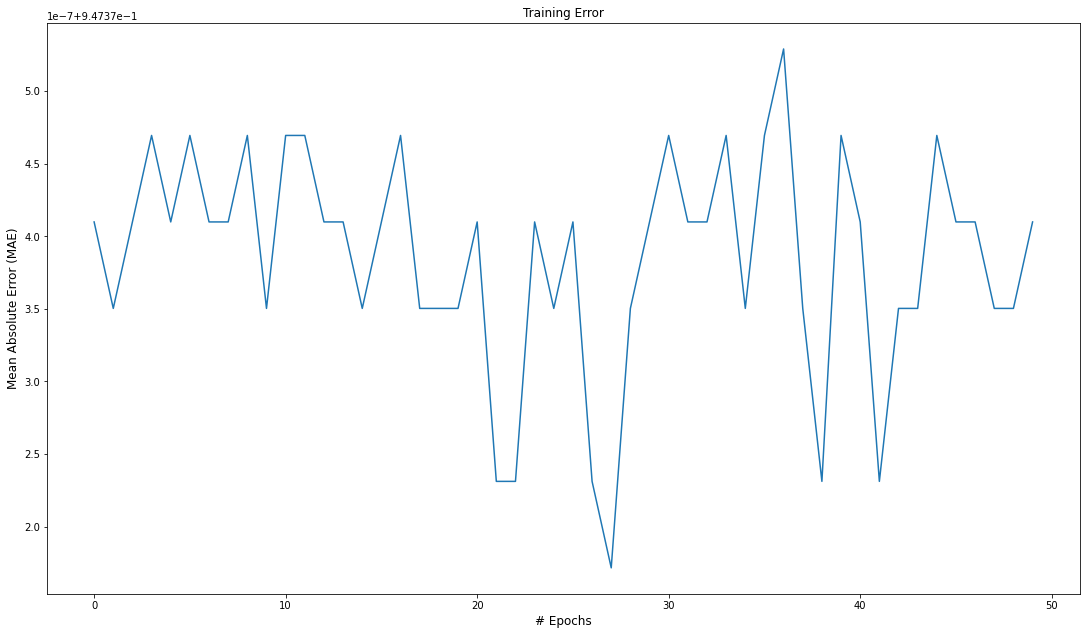

In [139]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Training Error')

if conc_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
fig.set_size_inches(18.5, 10.5)
plt.show()